In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import CategoricalDtype

from scipy import stats

c:\Users\fuq01\AppData\Local\anaconda3\envs\leap\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\fuq01\AppData\Local\anaconda3\envs\leap\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\fuq01\AppData\Local\anaconda3\envs\leap\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
baseline = pd.read_csv(f'../prolific_3T_2023/master_data/LEAP_baseline_ug_n245_screened.csv')
week1 = pd.read_csv(f'../prolific_3T_2023/master_data/ug_round2/LEAP_Round2_ug_all_Jan24.csv')
month1 = pd.read_csv(f'../prolific_3T_2023/master_data/ug_round3/LEAP_Round3_ug_all_Dec23.csv')

In [3]:
# check for missing clinical data
ids_nomising = baseline.dropna(subset=['bdi_total'])
ids_nomising = ids_nomising.reset_index(drop=True)
all_ids = ids_nomising['participant'].unique() #subjects have all behavior and psych data

baseline = baseline[baseline['participant'].isin(all_ids)]
week1 = week1[week1['participant'].isin(all_ids)]
month1 = month1[month1['participant'].isin(all_ids)]

In [4]:
# check unique prolific ids in each dataset
print('baseline n = ', baseline['participant'].nunique())
print('week1 n = ', week1['participant'].nunique())
print('month1 n = ', month1['participant'].nunique())

# check if all participants in baseline are in week1 and month1
print('baseline in week 1:', all([x in week1['participant'].unique() for x in baseline['participant'].unique()]))
print('baseline in month 1:', all([x in month1['participant'].unique() for x in baseline['participant'].unique()]))

baseline n =  236
week1 n =  129
month1 n =  129
baseline in week 1: False
baseline in month 1: False


# Add clinical scores

In [5]:
bdi = pd.read_csv('../prolific_3T_2023/online_round1_ug_screening/LEAPBDI.csv')
bdi = bdi.rename(columns={"prolific_pid":"participant", "Score":"bdi_score"})

pvss = pd.read_csv('../prolific_3T_2023/online_round1_ug_screening/LEAPPVSS.csv')
pvss = pvss.rename(columns={"prolific_pid":"participant", "pvss_TOTAL":"pvss_score"})

t1_clean = pd.read_csv('../prolific_3T_2023/online_round1_ug_screening/cleandataT1.csv')
sas = t1_clean[['prolific_pid','sas_total', 'bai_total']]
sas = sas.rename(columns={"prolific_pid":"participant", "sas_total":"apathy_score", 'bai_total':"anxiety_score"})

# merge all psych data based on participant id
psych_data = pd.merge(bdi, pvss, on='participant')[['participant', 'bdi_total', 'pvss_score']]
psych_data.head()

,participant,bdi_total,pvss_score
0,5d1855f26be726001a39cf9b,3.0,69
1,6101d433c8a23b9b39e41009,35.0,84
2,60fcbc5369b93b4dc6c26e16,1.0,174
3,603595f7c81d8e6ceaa65476,28.0,115
4,56c3ee7411e094000dd4654d,25.0,109


# Demographics data cleaning & recoding (supplementary code)

In [6]:
# load raw data set for demographics
demo_raw = pd.read_csv(f'../prolific_3T_2023/online_round1_ug_screening/cleandataT1.csv')
demographics = demo_raw[demo_raw.columns[:33]]
demographics.columns

Index(['Unnamed: 0', 'record_id', 'prolific_pid', 'demographics_timestamp',
       'age', 'sex', 'gender', 'hit', 'race___1', 'race___2', 'race___3',
       'race___4', 'race___5', 'race___6', 'race___7', 'race___8',
       'race_other', 'edu_level', 'attention_3', 'marriage', 'handedness',
       'polit_party', 'polit_party_other', 'sm1', 'job', 'job_other',
       'occupation', 'income', 'ladder_us', 'religion', 'state', 'zip_code',
       'adjust'],
      dtype='object')

In [7]:
# find proflicids id in demographics from baseline ids
demographics['participant'] = demographics['prolific_pid']
demographics = demographics[demographics['participant'].isin(baseline['participant'].unique())]

C:\Users\fuq01\AppData\Local\Temp\ipykernel_28796\2846666698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics['participant'] = demographics['prolific_pid']


In [8]:
# create dictionary to map race id to race
# 1, American Indian or Alaska Native | 2, Asian | 3, Black or African American | 4, Latino or Hispanic | 5, Multiracial | 6, Native Hawaiian or Pacific Islander | 7, White | 8, Other

race_dict = {'race___1': 'American Indian or Alaska Native', 'race___2': 'Asian', 'race___3': 'Black or African American', 'race___4': 'Latino or Hispanic', 'race___5': 'Multiracial', 'race___6': 'Native Hawaiian or Pacific Islander', 'race___7': 'White', 'race___8': 'Other'}
race = demographics[['prolific_pid', 'race___1', 'race___2', 'race___3', 'race___4', 'race___5', 'race___6', 'race___7', 'race___8']]
race.rename(columns=race_dict, inplace=True)

# reformat dataframe
race = pd.melt(race, id_vars=['prolific_pid'], var_name='race', value_name='Binary_Code')
race = race[race['Binary_Code'] == 1] # Filter out rows with Binary_Code == 1 / reported race
race = race.drop(columns=['Binary_Code']) # Drop the Binary_Code column

#recode for multiple selection to a single multiracial label
multi_race_ids = race[race['prolific_pid'].duplicated(keep=False)].groupby('prolific_pid').apply(lambda x: len(x['race']) > 1)
race.loc[race['prolific_pid'].isin(multi_race_ids[multi_race_ids].index), 'race'] = 'Multiracial'
race.drop_duplicates(subset=['prolific_pid'], keep='first', inplace=True) # Drop duplicate rows (keeping the first occurrence)

# Reset the index
race = race.reset_index(drop=True)
race = race.sort_values('race', ascending=True)
race.describe()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_28796\2337661371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race.rename(columns=race_dict, inplace=True)


,prolific_pid,race
count,236,236
unique,236,7
top,5c55faafb571e7000119e576,White
freq,1,161


In [9]:
# clean data for income (earning up to a certain amount)
#  1, Less than $10,000 | 2, $10,000 to $19,999 | 3, $20,000 to $29,999 | 4, $30,000 to $39,999 | 5, $40,000 to $49,999 | 6, $50,000 to $59,999 | 7, $60,000 to $69,999 | 8, $70,000 to $79,999 | 9, $80,000 to $89,999 | 10, $90,000 to $99,999 | 11, $100,000 to $149,999 | 12, $150,000 or more

income_dict = {1: '< $10,000', 2: '$20,000', 3: '$30,000', 4: '$40,000', 5: '$50,000', 6: '$60,000', 7: '$70,000', 8: '$80,000', 9: '$90,000', 10: '$100,000', 11: '$150,000', 12: ' > $150,000'}
income_list = list(income_dict.values())

income = demographics[['prolific_pid', 'income']]
income = income.sort_values('income', ascending=False)
income['income'] = income['income'].map(income_dict)
income['income_order'] = income['income'].map({v: k for k, v in income_dict.items()})
income.head()

,prolific_pid,income,income_order
28,5f405adcda0ade19c87826bd,"> $150,000",12
131,6307bee7b345c1bf0fb2f362,"> $150,000",12
50,607357623fd10fe43a18787c,"> $150,000",12
215,5f6f738fef894f0dbf9839f8,"> $150,000",12
34,5aeb46c5ed102400010f26cb,"> $150,000",12


In [10]:
# screen for prior diagnosises
diag_df = demo_raw[['prolific_pid', 'adhd', "autism","bipolar","avpd","bpd","mdd","ed","gad","ocd","ld","panic","gambling","ptsd","scz","spd","sad","tourettes","sud","other_disorder"]]

nan_list = ['no', 'none', 'None', 'None.', 'na']
diag_df.loc[:, 'other_disorder'] = diag_df['other_disorder'].replace(nan_list, float('nan'))
diag_df.loc[:, 'other_disorder_b'] = diag_df['other_disorder'].notnull().astype(int)

# sum across all columns except for 'prolific_pid'
diag_df['total_prior_diag'] = diag_df.iloc[:, 1:].sum(axis=1)
diag_df.loc[:, 'total_prior_diag'] += diag_df['other_disorder_b']
diag_df['md_anx_prior_diag'] = diag_df.eval('bipolar + mdd + gad + panic + ptsd + sad')
diag_df['non_md_prior_diag'] = diag_df.eval('adhd + autism + avpd + bpd + ed + ocd + ld + gambling + scz + spd + tourettes + sud + other_disorder_b')

no_prior_dia_n = diag_df['total_prior_diag'].value_counts()[0]
no_prior_md_n = diag_df['md_anx_prior_diag'].value_counts()[0]
print(f'Number of participants with no prior diagnosis: {no_prior_dia_n}')
print(f'Number of participants with no prior mood or anxiety diagnosis: {no_prior_md_n} \n\n\n')

Number of participants with no prior diagnosis: 145
Number of participants with no prior mood or anxiety diagnosis: 156 





C:\Users\fuq01\AppData\Local\Temp\ipykernel_28796\2279390768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_df.loc[:, 'other_disorder'] = diag_df['other_disorder'].replace(nan_list, float('nan'))
C:\Users\fuq01\AppData\Local\Temp\ipykernel_28796\2279390768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_df.loc[:, 'other_disorder_b'] = diag_df['other_disorder'].notnull().astype(int)
C:\Users\fuq01\AppData\Local\Temp\ipykernel_28796\2279390768.py:9: FutureWarning: Dropping of nuisance colum

In [11]:
# sex and gender mismatch check
demographics.loc[:, 'queer'] = 0  # Initialize all values to 0
non_binary_other = [3, 4]  # Additional gender values to consider as non-binary or other

# Set 'queer' to 1 where 'sex' and 'gender' don't match, or 'gender' is non-binary or other
demographics.loc[(demographics['sex'] != demographics['gender']) | demographics['gender'].isin(non_binary_other) | demographics['sex'].isin(non_binary_other), 'queer'] = 1
queer_n = demographics['queer'].value_counts()[1]
q_df = demographics[demographics['queer'] == 1]
print(f'Number of queer participants: {queer_n}')

Number of queer participants: 6


In [12]:
# select key demographics variables
demo_keys = demographics[['prolific_pid', 'age', 'sex', 'gender', 'edu_level', 'ladder_us', 'queer']]
demo_keys.head()

# merge demo_keys with race and income using prolific_pid
demo_keys = pd.merge(demo_keys, income, on='prolific_pid')
demo_keys = pd.merge(demo_keys, race, on='prolific_pid')
demo_keys = pd.merge(demo_keys, diag_df[['prolific_pid', 'total_prior_diag', 'md_anx_prior_diag', 'non_md_prior_diag']], on='prolific_pid')
demo_keys.rename(columns={'prolific_pid': 'participant'}, inplace=True)
demo_keys.head()

,participant,age,sex,gender,edu_level,ladder_us,queer,income,income_order,race,total_prior_diag,md_anx_prior_diag,non_md_prior_diag
0,61006614d4c56450afce3a6b,30,2,2,6,5,0,"$90,000",9,Latino or Hispanic,0,0,0
1,5c935d881754ba001b25697a,38,2,2,5,5,0,"> $150,000",12,White,1,1,0
2,6078163f1e585e4f71e3b879,61,2,2,4,4,0,"$100,000",10,White,0,0,0
3,61533552778007d9dbe260f2,40,1,1,4,4,0,"$70,000",7,White,0,0,0
4,5c0023fb2213be0001c2cdde,32,2,2,3,4,0,"$60,000",6,White,3,0,2


# Overall demographics summary

Data dictionary

sex: 1, Male | 2, Female | 3, Other   

gender: 1, Man | 2, Woman | 3, Non-Binary | 4, Other  

edu_level: 1, 1-8 Less than high school | 2, 9-11 Some high school | 3, 12 High school degree | 4, 13-15 Some college | 5, 16 Bachelor's degree in college (4-year) | 6, 17-25 Graduate School 

income: 1, Less than $10,000 | 2, $10,000 to $19,999 | 3, $20,000 to $29,999 | 4, $30,000 to $39,999 | 5, $40,000 to $49,999 | 6, $50,000 to $59,999 | 7, $60,000 to $69,999 | 8, $70,000 to $79,999 | 9, $80,000 to $89,999 | 10, $90,000 to $99,999 | 11, $100,000 to $149,999 | 12, $150,000 or more      

race: 1, American Indian or Alaska Native | 2, Asian | 3, Black or African American | 4, Latino or Hispanic | 5, Multiracial | 6, Native Hawaiian or Pacific Islander | 7, White | 8, Other   

ladder_us: 1~10 scale

In [13]:
# overall demo_key summary
# mean age and std
print('mean age = ', demo_keys['age'].mean(), 'std =', demo_keys['age'].std())
# percentage of sex (2 = female)
print('percentage female = ', demo_keys['sex'].value_counts(normalize=True)[2]*100, '%')
# percentage of gender (2 = woman)
print('percentage woman = ', demo_keys['gender'].value_counts(normalize=True)[2]*100, '%')
# percentage of queer (1 = non-binary, other, transgender)
print('percentage queer = ', demo_keys['queer'].value_counts(normalize=True)[1]*100, '%')
# percentage of white (7 = white)
print('percentage white = ', demo_keys['race'].value_counts(normalize=True)['White']*100, '%')
# education level mode 
print('education level mode = ', demo_keys['edu_level'].mode()[0], 'Bachelor\'s degree in college (4-year)')
# income mode
print('income mode = ', demo_keys['income'].mode()[0])
# ladder mode, ladder mean
print('ladder mode = ', demo_keys['ladder_us'].mode()[0], 'ladder mean = ', demo_keys['ladder_us'].mean())
# percentage of zero prior diagnosis
print('percentage no prior diagnosis = ', demo_keys['total_prior_diag'].value_counts(normalize=True)[0]*100, '%')

mean age =  41.728813559322035 std = 10.003966036463192
percentage female =  51.69491525423729 %
percentage woman =  49.57627118644068 %
percentage queer =  2.5423728813559325 %
percentage white =  68.22033898305084 %
education level mode =  5 Bachelor's degree in college (4-year)
income mode =  $40,000
ladder mode =  3 ladder mean =  4.470338983050848
percentage no prior diagnosis =  56.779661016949156 %


# plots

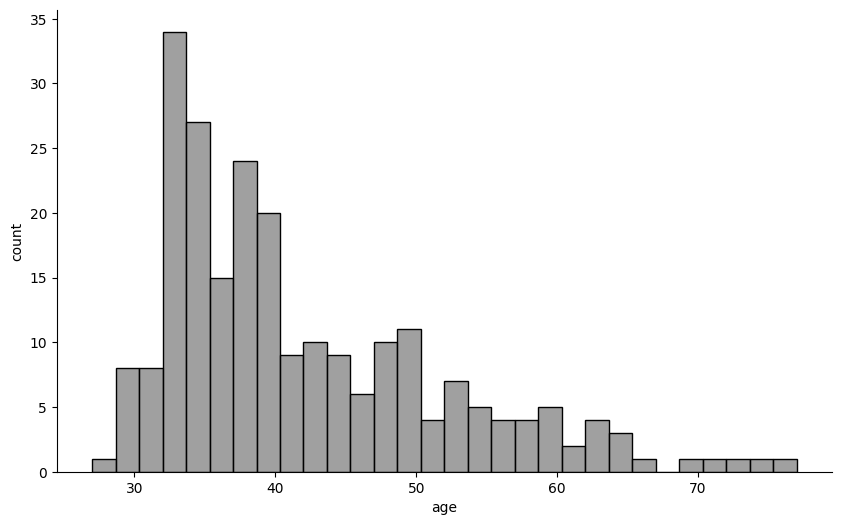

In [13]:
# plot Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(demo_keys['age'], kde=False, bins=30, color='grey')
plt.xlabel('age')
plt.ylabel('count')

sns.despine()

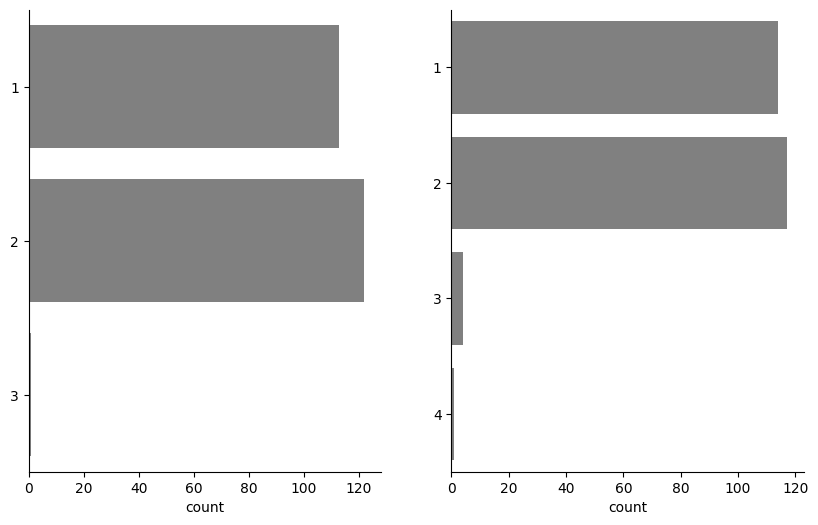

In [14]:
# plot sex and gender 
fig, ax = plt.subplots(1, 2, figsize=(10,6))

sns.countplot(data=demo_keys, y='sex', orient='h', color='grey', ax=ax[0])
# ax[0].set_yticklabels(['male', 'female'])
ax[0].set_ylabel('')

sns.countplot(data=demo_keys, y='gender', orient='h', ax=ax[1], color='grey')
# ax[1].set_yticklabels(['man', 'woman', 'non-binary'])
ax[1].set_ylabel('')

sns.despine()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_18776\4265311126.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(label)


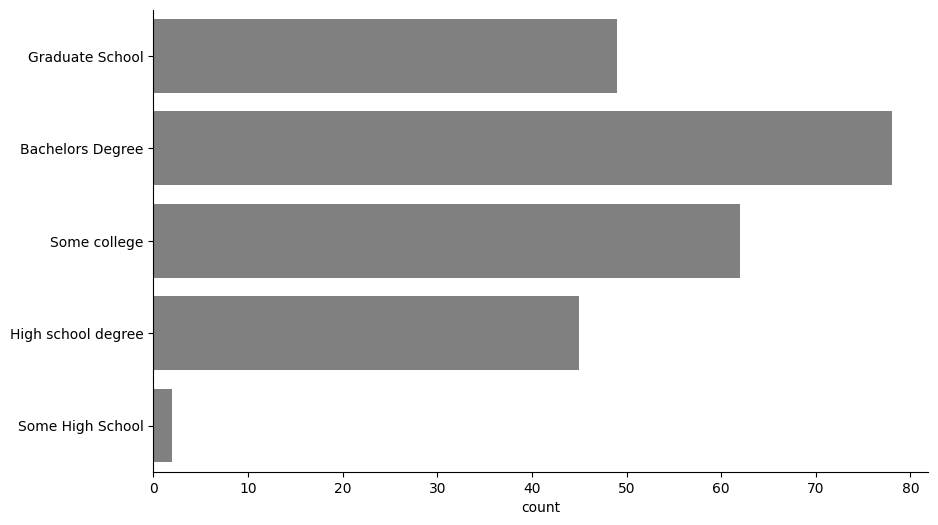

In [15]:
# plot education level 
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = demo_keys, y='edu_level', orient='h', color='grey', order=[6,5,4,3,2])
label = ['Some High School', 'High school degree', 'Some college', 'Bachelors Degree', 'Graduate School']
label.reverse()
ax.set_yticklabels(label)
ax.set_ylabel('')
sns.despine()

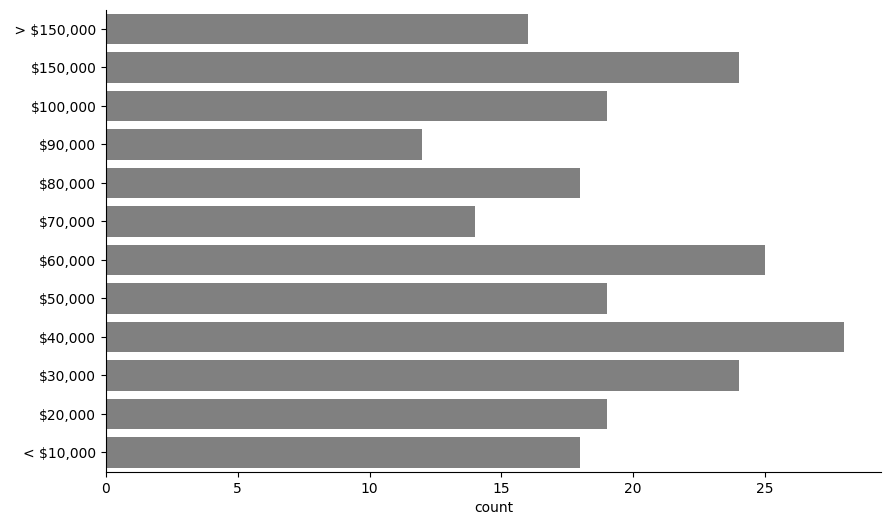

In [16]:
# plot income
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = income, y='income', orient='h', color='grey')
ax.set_ylabel('')
sns.despine()

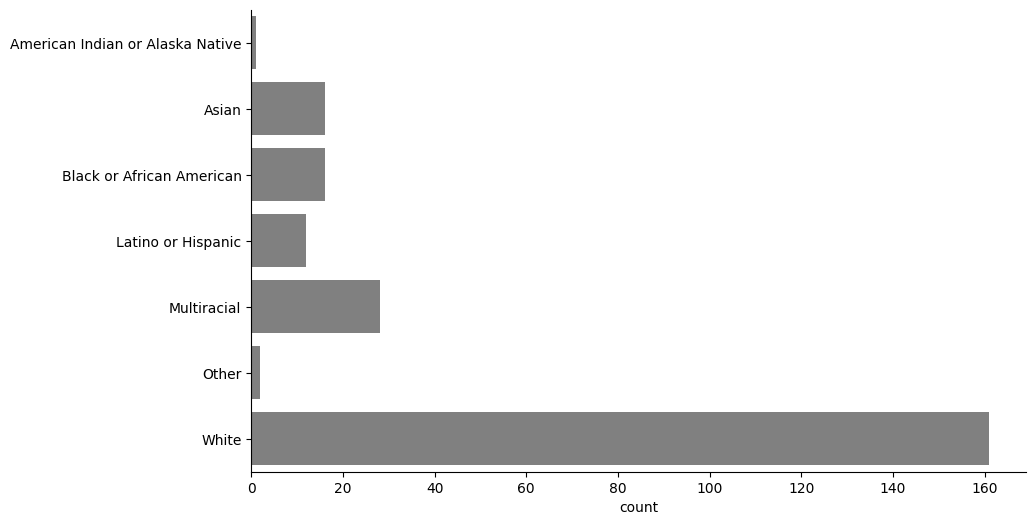

In [17]:
# plot race
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = race, y='race', orient='h', color='grey')
ax.set_ylabel('')
sns.despine()

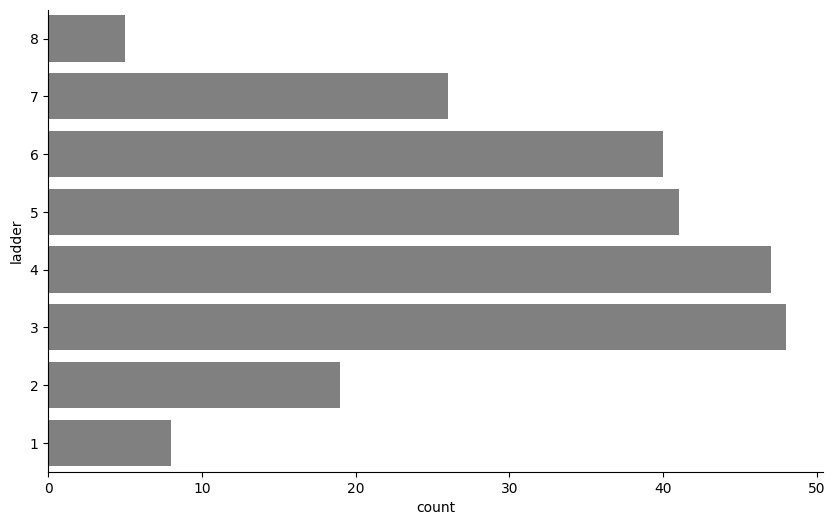

In [18]:
# plot ladder
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = demo_keys, y='ladder_us', orient='h', color='grey', order=[8,7,6,5,4,3,2,1])
plt.xlabel('count')
plt.ylabel('ladder')
sns.despine()

# Demographics by groups

In [14]:
# merge baseline and demo_keys 
groups = baseline[['participant', 'group']].drop_duplicates().reset_index()
baseline_all = pd.merge(groups, demo_keys, on='participant', how='left')

In [15]:
# data formatting
def format(df):
    cat_order = CategoricalDtype(['Healthy','Depression','Anhedonia','Both'], ordered=True)
    df['group']= df['group'].astype(cat_order)
    df.sort_values('group')

    return df 

baseline_all = format(baseline_all)
print(baseline_all.columns)

Index(['index', 'participant', 'group', 'age', 'sex', 'gender', 'edu_level',
       'ladder_us', 'queer', 'income', 'income_order', 'race',
       'total_prior_diag', 'md_anx_prior_diag', 'non_md_prior_diag'],
      dtype='object')


In [16]:
# Group count 
group_count = baseline_all['group'].value_counts()
print(group_count)

Healthy       91
Both          71
Anhedonia     45
Depression    29
Name: group, dtype: int64


In [17]:
# Simple contrast coding for depression and anhedonia 
baseline_all['depression'] = baseline_all['group'].apply(lambda x: 1 if x in ['Depression', 'Both'] else 0)
baseline_all['anhedonia'] = baseline_all['group'].apply(lambda x: 1 if x in ['Anhedonia', 'Both'] else 0)

In [18]:
# only allow prior mood related diagnosis  
baseline_all['participant'].nunique()

236

# Demographics by group writing table! (supplementary code chunk)

In [20]:
# merge baseline_all with psych_data based on participant id
baseline_all = pd.merge(baseline_all, psych_data, on='participant')

In [21]:
# do 2-way ANOVA using depression and anhedonia as factors for age, and get p-value
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import statsmodels.stats.anova as anova

formula = 'age ~ C(depression) * C(anhedonia)'
model = ols(formula, data=baseline_all).fit()
anova_results = anova.anova_lm(model, typ=2)
anova_results

,sum_sq,df,F,PR(>F)
C(depression),145.893633,1.0,1.463140,0.227662
C(anhedonia),56.106622,1.0,0.562683,0.453941
C(depression):C(anhedonia),71.409258,1.0,0.716150,0.398282
Residual,23133.349120,232.0,NaN,NaN


In [22]:
baseline_all

,index,participant,group,age,sex,gender,edu_level,ladder_us,queer,income,income_order,race,total_prior_diag,md_anx_prior_diag,non_md_prior_diag,depression,anhedonia,bdi_total,pvss_score
0,0,5c62c8c594e3bc0001d66cf8,Healthy,37,1,1,2,3,0,"$60,000",6,White,0,0,0,0,0,12.0,154
1,54,60a7d7b70d3cf8f48a8a490d,Both,33,1,1,5,2,0,"$80,000",8,White,2,1,1,1,1,14.0,125
2,111,54847f1cfdf99b07b28f22f9,Anhedonia,50,1,1,5,3,0,"$30,000",3,Black or African American,0,0,0,0,1,0.0,131
3,170,54e32a60fdf99b3eae9de85b,Both,38,2,2,5,2,0,"$70,000",7,White,1,1,0,1,1,23.0,66
4,223,559002fefdf99b3f7aada38f,Both,38,1,1,5,3,0,"$40,000",4,White,2,2,0,1,1,24.0,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,14275,63ae31ff5c725a41082afc56,Both,51,2,2,5,6,0,"$150,000",11,White,3,2,1,1,1,25.0,108
232,14334,63b6cee06aaa9fc9669b8cc2,Healthy,41,2,2,3,3,0,"$40,000",4,White,0,0,0,0,0,2.0,160
233,14394,63c34086cb929e7c9b844a67,Anhedonia,40,1,1,5,7,0,"$80,000",8,White,0,0,0,0,1,7.0,131
234,14514,63d15717bf9f5277f27bbe5e,Both,36,2,2,5,4,0,"$70,000",7,Black or African American,1,1,0,1,1,17.0,108


In [25]:
# Mean age and standard deviation
age = baseline_all.groupby('group')['age'].mean().reset_index()
std = baseline_all.groupby('group')['age'].std().reset_index()
demo_group_df = pd.merge(age, std, on='group', suffixes=('_mean', '_std'))

# ANOVA for age across groups
anova_age = stats.f_oneway(*(baseline_all[baseline_all['group'] == group]['age'] for group in baseline_all['group'].unique()))
demo_group_df['anova_age_p_value'] = anova_age.pvalue

# Female sex count and percentage
sex = baseline_all.groupby('group')['sex'].value_counts(normalize=False).reset_index(name='female_count')
sex_percent = baseline_all.groupby('group')['sex'].value_counts(normalize=True).reset_index(name='female_percent')
sex_combined = pd.merge(sex, sex_percent, on=['group', 'sex'])
sex_combined = sex_combined[sex_combined['sex'] == 2].drop(columns='sex')
demo_group_df = pd.merge(demo_group_df, sex_combined, on='group')

# Woman gender count and percentage
gender = baseline_all.groupby('group')['gender'].value_counts(normalize=False).reset_index(name='woman_count')
gender_percent = baseline_all.groupby('group')['gender'].value_counts(normalize=True).reset_index(name='woman_percent')
gender_combined = pd.merge(gender, gender_percent, on=['group', 'gender'])
gender_combined = gender_combined[gender_combined['gender'] == 2].drop(columns='gender')
demo_group_df = pd.merge(demo_group_df, gender_combined, on='group')

# Each race count and percentage
race = baseline_all.groupby('group')['race'].value_counts(normalize=False).reset_index(name='race_count')
race_percent = baseline_all.groupby('group')['race'].value_counts(normalize=True).reset_index(name='race_percent')
race_combined = pd.merge(race, race_percent, on=['group', 'race'])
demo_group_df = pd.merge(demo_group_df, race_combined, on='group', how='left')

# Education mode
edu = baseline_all.groupby(['group'])['edu_level'].agg(pd.Series.median).reset_index(name='edu_med')
demo_group_df = pd.merge(demo_group_df, edu, on='group')

# Income mode
income = baseline_all.groupby(['group'])['income_order'].agg(pd.Series.median).reset_index(name='income_med')
demo_group_df = pd.merge(demo_group_df, income, on='group')

# US Ladder mode
ladder = baseline_all.groupby(['group'])['ladder_us'].agg(pd.Series.median).reset_index(name='ladder_med')
demo_group_df = pd.merge(demo_group_df, ladder, on='group')

# Prior mood diagnosis mean
prior_diag = baseline_all.groupby('group')['md_anx_prior_diag'].mean().reset_index(name='mood_prior_diag_mean')
prior_diag_std = baseline_all.groupby('group')['md_anx_prior_diag'].std().reset_index(name='mood_prior_diag_std')
demo_group_df = pd.merge(demo_group_df, prior_diag, on='group')
demo_group_df = pd.merge(demo_group_df, prior_diag_std, on='group')
# ANOVA for mood diagnosis across groups
anova_dia = stats.f_oneway(*(baseline_all[baseline_all['group'] == group]['md_anx_prior_diag'] for group in baseline_all['group'].unique()))
demo_group_df['anova_diag_p_value'] = anova_dia.pvalue

# mean PVSS score
pvss = baseline_all.groupby('group')['pvss_score'].mean().reset_index(name='pvss_mean')
pvss_std = baseline_all.groupby('group')['pvss_score'].std().reset_index(name='pvss_std')
demo_group_df = pd.merge(demo_group_df, pvss, on='group')
demo_group_df = pd.merge(demo_group_df, pvss_std, on='group')
# ANOVA for BDI across groups
anova_pvss = stats.f_oneway(*(baseline_all[baseline_all['group'] == group]['pvss_score'] for group in baseline_all['group'].unique()))
demo_group_df['anova_pvss_p_value'] = anova_pvss.pvalue

# mean BDI score
bdi = baseline_all.groupby('group')['bdi_total'].mean().reset_index(name='bdi_mean')
bdi_std = baseline_all.groupby('group')['bdi_total'].std().reset_index(name='bdi_std')
demo_group_df = pd.merge(demo_group_df, bdi, on='group')
demo_group_df = pd.merge(demo_group_df, bdi_std, on='group')
# ANOVA for BDI across groups
anova_bdi = stats.f_oneway(*(baseline_all[baseline_all['group'] == group]['bdi_total'] for group in baseline_all['group'].unique()))
demo_group_df['anova_bdi_p_value'] = anova_bdi.pvalue

demo_group_df.head()
demo_group_df.to_csv('../4.online_study_nbs/lme_results/demo_group_writing.csv', index=False)

In [29]:
 # do Kruskal-Wallis H Test 
from scipy.stats import kruskal

ordinal_var = 'ladder_us'

depression = baseline_all[baseline_all['depression'] == 1][ordinal_var]
anhedonia = baseline_all[baseline_all['anhedonia'] == 1][ordinal_var]
both = baseline_all[(baseline_all['depression'] == 1) & (baseline_all['anhedonia'] == 1)][ordinal_var]
neither = baseline_all[(baseline_all['depression'] == 0) & (baseline_all['anhedonia'] == 0)][ordinal_var]

kruskal(depression, anhedonia, both, neither)

KruskalResult(statistic=30.877249355392898, pvalue=9.021688630584881e-07)

In [26]:
# print unique participants in each group 
baseline_all.groupby('group')['participant'].nunique()

group
Healthy       91
Depression    29
Anhedonia     45
Both          71
Name: participant, dtype: int64

-0.43482483285733503 2.641661129872584e-12


Text(0.95, 0.1, 'Pearson r = -0.43\np = 2.64e-12')

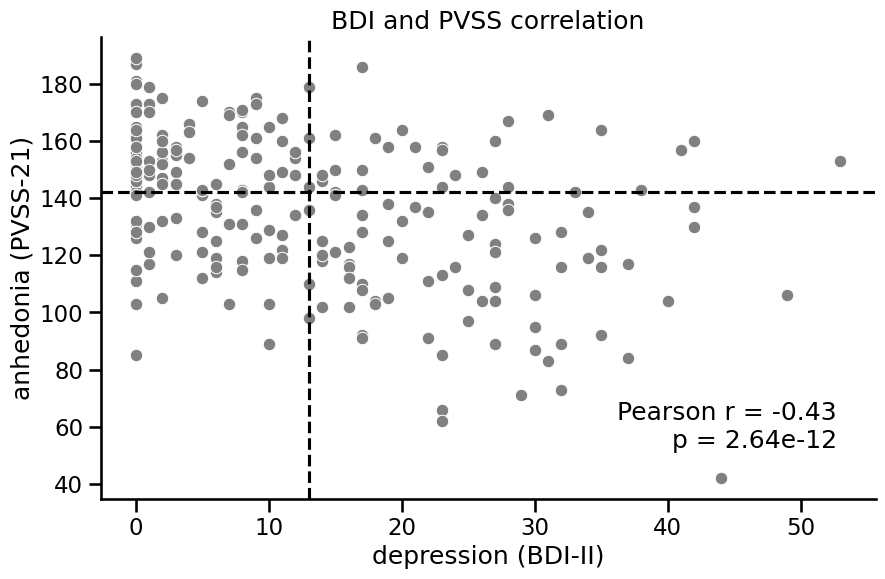

In [137]:
# Figure 1 grouping illustration plot
sns.set_context('talk')
# correlation plot between BDI and PVSS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=baseline_all, x='bdi_total', y='pvss_score', color='grey')
# add a vertical line at 13
plt.axvline(x=13, color='black', linestyle='--')
# add a horizontal line at 142
plt.axhline(y=142, color='black', linestyle='--')
plt.xlabel('depression (BDI-II)')
plt.ylabel('anhedonia (PVSS-21)')
plt.title('BDI and PVSS correlation')
sns.despine()

# add pearson correlation coefficient and p-value
corr, p = stats.pearsonr(baseline_all['bdi_total'], baseline_all['pvss_score'])
print(corr, p)

# move text to bottom right
plt.text(0.95, 0.10, f'Pearson r = {corr:.2f}\np = {p:.2e}', ha='right', va='bottom', transform=plt.gca().transAxes)
# plt.text(0.5, 0.9, f'Pearson correlation = {corr:.2f}\np-value = {p:.2e}', ha='center', va='center', transform=plt.gca().transAxes)

# old tables

In [33]:
# categorical percentage per group
demo_var = 'edu_level'

group_counts = baseline_all.groupby(['group', demo_var]).size()
total_counts = baseline_all.groupby('group').size() # Calculate the total counts for each group
percentages = (group_counts / total_counts * 100).unstack() # Calculate the percentage of demos for each group
percentages

edu_level,2,3,4,5,6
group,,,,,
Healthy,1.098901,17.582418,27.472527,25.274725,28.571429
Depression,0.000000,20.689655,34.482759,24.137931,20.689655
Anhedonia,2.222222,17.777778,17.777778,40.000000,22.222222
Both,0.000000,21.126761,26.760563,42.253521,9.859155


In [34]:
# income table
group_counts = baseline_all.groupby(['group', 'income']).size()
total_counts = baseline_all.groupby('group').size() # Calculate the total counts for each group
percentages = (group_counts / total_counts * 100).unstack() # Calculate the percentage of demos for each group
percentages = percentages[income_list]
percentages

income,"< $10,000","$20,000","$30,000","$40,000","$50,000","$60,000","$70,000","$80,000","$90,000","$100,000","$150,000","> $150,000"
group,,,,,,,,,,,,
Healthy,2.197802,4.395604,12.087912,12.087912,6.593407,13.186813,4.395604,6.593407,6.593407,8.791209,15.384615,7.692308
Depression,17.241379,13.793103,3.448276,10.344828,10.344828,3.448276,17.241379,0.000000,0.000000,10.344828,6.896552,6.896552
Anhedonia,6.666667,8.888889,11.111111,17.777778,8.888889,4.444444,2.222222,13.333333,4.444444,8.888889,6.666667,6.666667
Both,11.267606,9.859155,9.859155,8.450704,8.450704,14.084507,5.633803,8.450704,5.633803,5.633803,7.042254,5.633803


# Old graphs

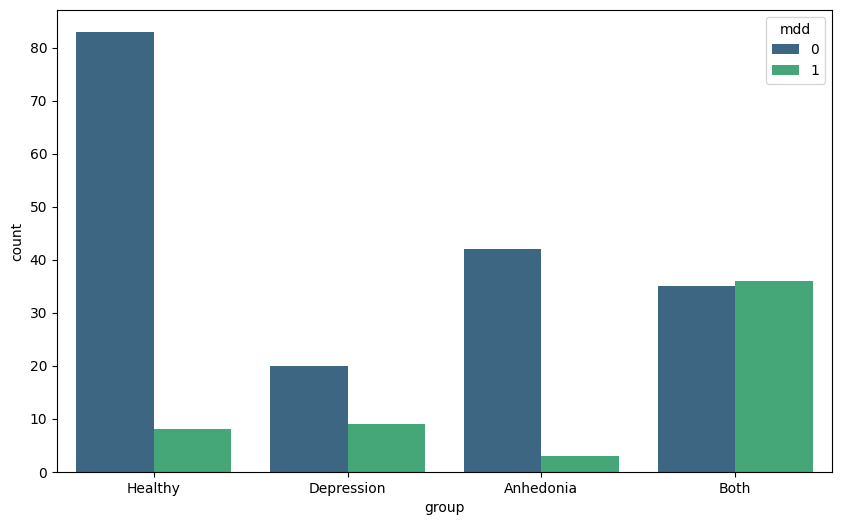

In [35]:
# plot previous mdd diagnosis by group
plt.figure(figsize=(10, 6))
diag_df = diag_df.merge(baseline_all[['participant', 'group']], left_on='prolific_pid', right_on='participant')
ax = sns.countplot(data=diag_df, x='group', hue='mdd', palette='viridis')
# # plt.xlabel('total prior diagnosis')
# diag_df = diag_df.merge(baseline_all[['participant', 'group']], left_on='prolific_pid', right_on='participant')
# diag_df

C:\Users\fuq01\AppData\Local\Temp\ipykernel_18776\75833903.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=baseline_all, x="group", y='age', errorbar=('se',1), palette='Set2')


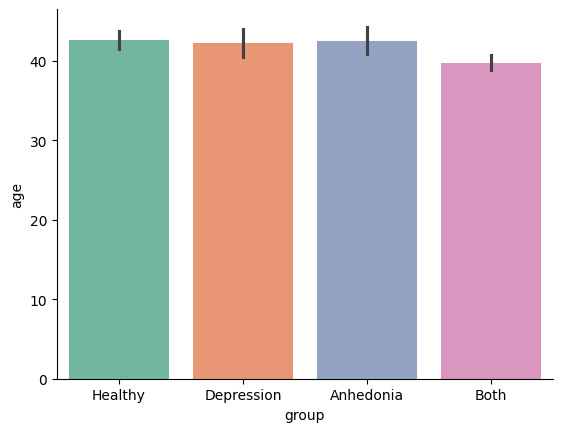

In [36]:
ax = sns.barplot(data=baseline_all, x="group", y='age', errorbar=('se',1), palette='Set2')
sns.despine(trim=False)

In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# 1-way ANOVA
model = ols('sex ~ group', data=baseline_all).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
print(anova_table)

             df     sum_sq   mean_sq         F    PR(>F)
group       3.0   1.454726  0.484909  1.894151  0.131292
Residual  232.0  59.392732  0.256003       NaN       NaN


C:\Users\fuq01\AppData\Local\Temp\ipykernel_18776\3270860353.py:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  ax = sns.countplot(data=baseline_all, x="group", hue='sex', color='grey')


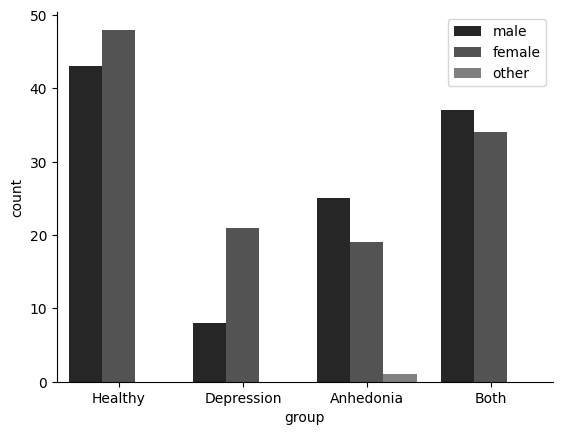

In [38]:
ax = sns.countplot(data=baseline_all, x="group", hue='sex', color='grey')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['male', 'female', 'other'])
sns.despine(trim=False)

C:\Users\fuq01\AppData\Local\Temp\ipykernel_18776\3921366284.py:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  ax = sns.countplot(data=baseline_all, x="group", hue='gender', color='grey')


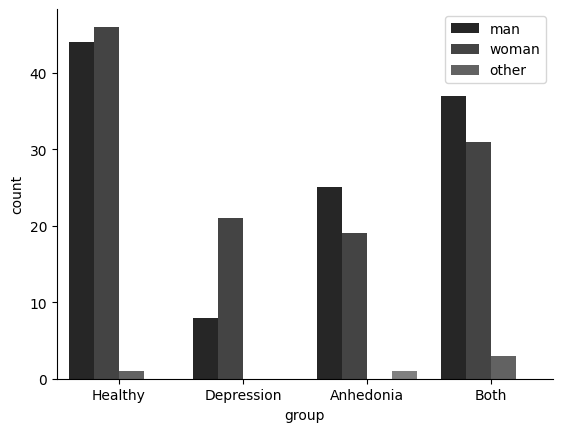

In [39]:
ax = sns.countplot(data=baseline_all, x="group", hue='gender', color='grey')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['man', 'woman', 'other'])
sns.despine(trim=False)

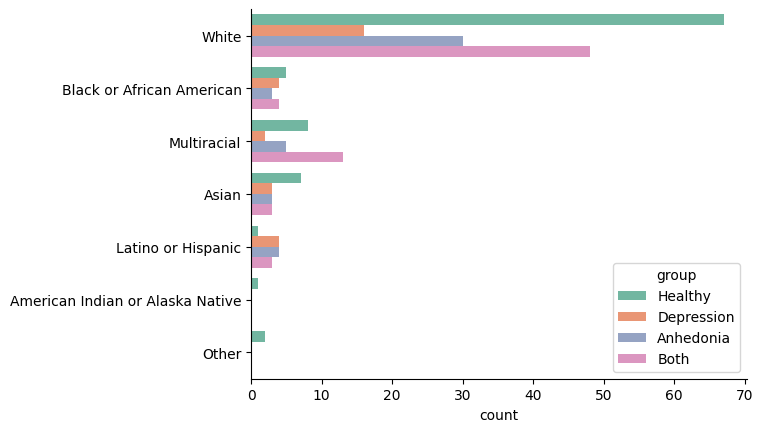

In [40]:
# plot race
ax = sns.countplot(data = baseline_all, y='race', hue='group', orient='h', palette='Set2')
ax.set_ylabel('')
sns.despine()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_18776\2813536197.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(label)


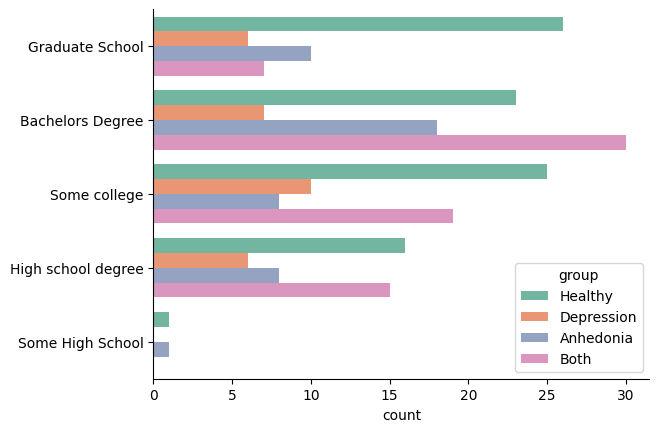

In [41]:
# plot education level 
ax = sns.countplot(data = baseline_all, y='edu_level', hue='group', orient='h', order=[6,5,4,3,2], palette='Set2')
label = ['Some High School', 'High school degree', 'Some college', 'Bachelors Degree', 'Graduate School']
label.reverse()
ax.set_yticklabels(label)
ax.set_ylabel('')
sns.despine()

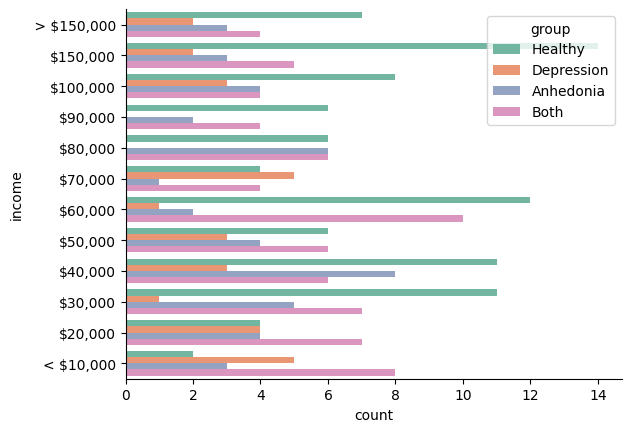

In [42]:
income_list.reverse()
ax = sns.countplot(data=baseline_all, y="income", hue='group', orient='h', order=income_list, palette='Set2')
sns.despine(trim=False)

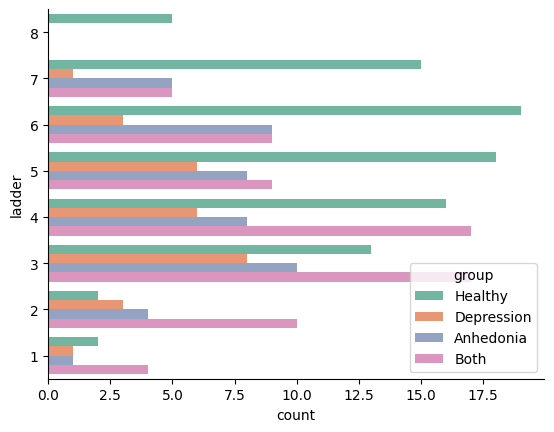

In [43]:
ax = sns.countplot(data = baseline_all, y='ladder_us', hue='group', orient='h', palette='Set2', order=[8,7,6,5,4,3,2,1])
plt.xlabel('count')
plt.ylabel('ladder')
sns.despine(trim=False)

In [44]:
# check for mood and anxiety prior diagnosis distribution for depression and anhedonia groups
baseline_all

,index,participant,group,age,sex,gender,edu_level,ladder_us,queer,income,income_order,race,total_prior_diag,md_anx_prior_diag,non_md_prior_diag,depression,anhedonia
0,0,5c62c8c594e3bc0001d66cf8,Healthy,37,1,1,2,3,0,"$60,000",6,White,0,0,0,0,0
1,54,60a7d7b70d3cf8f48a8a490d,Both,33,1,1,5,2,0,"$80,000",8,White,2,1,1,1,1
2,111,54847f1cfdf99b07b28f22f9,Anhedonia,50,1,1,5,3,0,"$30,000",3,Black or African American,0,0,0,0,1
3,170,54e32a60fdf99b3eae9de85b,Both,38,2,2,5,2,0,"$70,000",7,White,1,1,0,1,1
4,223,559002fefdf99b3f7aada38f,Both,38,1,1,5,3,0,"$40,000",4,White,2,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,14275,63ae31ff5c725a41082afc56,Both,51,2,2,5,6,0,"$150,000",11,White,3,2,1,1,1
232,14334,63b6cee06aaa9fc9669b8cc2,Healthy,41,2,2,3,3,0,"$40,000",4,White,0,0,0,0,0
233,14394,63c34086cb929e7c9b844a67,Anhedonia,40,1,1,5,7,0,"$80,000",8,White,0,0,0,0,1
234,14514,63d15717bf9f5277f27bbe5e,Both,36,2,2,5,4,0,"$70,000",7,Black or African American,1,1,0,1,1


# Stats

In [45]:
def chi_square(var, df):
    contingency_table = pd.crosstab(df[var], df['group'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    results = {
        'Chi-Square test for demographics': var,
        'Statistic': chi2,
        'Degrees of Freedom': dof,
        'P-value': p
    }
    
    return pd.DataFrame(results, index=[0])

In [105]:
# identity variables: WRITING Material
chi_df = pd.DataFrame()
chi_df = pd.concat([chi_df, chi_square('sex', baseline_all)])
chi_df = pd.concat([chi_df, chi_square('gender', baseline_all)])
chi_df = pd.concat([chi_df, chi_square('race', baseline_all)])
chi_df = pd.concat([chi_df, chi_square('edu_level', baseline_all)])
chi_df = pd.concat([chi_df, chi_square('income', baseline_all)])
chi_df = pd.concat([chi_df, chi_square('ladder_us', baseline_all)])
# chi_df = pd.concat([chi_df, chi_square('total_prior_diag', baseline_all)])
chi_df = pd.concat([chi_df, chi_square('queer', baseline_all)])

chi_df

,Chi-Square test for demographics,Statistic,Degrees of Freedom,P-value
0,sex,10.973488,6,0.089199
0,gender,15.711752,9,0.073150
0,race,22.104817,18,0.227365
0,edu_level,15.920736,12,0.194894
0,income,38.948949,33,0.219644
0,ladder_us,38.462205,27,0.070842
0,queer,1.630378,3,0.652522


# GLM UG data curation

In [47]:
baseline_all.head()

,index,participant,group,age,sex,gender,edu_level,ladder_us,queer,income,income_order,race,total_prior_diag,md_anx_prior_diag,non_md_prior_diag,depression,anhedonia
0,0,5c62c8c594e3bc0001d66cf8,Healthy,37,1,1,2,3,0,"$60,000",6,White,0,0,0,0,0
1,54,60a7d7b70d3cf8f48a8a490d,Both,33,1,1,5,2,0,"$80,000",8,White,2,1,1,1,1
2,111,54847f1cfdf99b07b28f22f9,Anhedonia,50,1,1,5,3,0,"$30,000",3,Black or African American,0,0,0,0,1
3,170,54e32a60fdf99b3eae9de85b,Both,38,2,2,5,2,0,"$70,000",7,White,1,1,0,1,1
4,223,559002fefdf99b3f7aada38f,Both,38,1,1,5,3,0,"$40,000",4,White,2,2,0,1,1


In [48]:
glm_ug = pd.merge(baseline, baseline_all, on=['participant', 'group']).reset_index(drop=True)
sample_n = glm_ug['participant'].nunique()
print('N =', sample_n)

N = 236


In [49]:
glm_ug.to_csv(f'../prolific_3T_2023/master_data/LEAP_baseline_ug_n{sample_n}_analysis.csv')

In [50]:
# Save n131 unique participants ids 
ids = glm_ug[['participant', 'group', 'bdi_total', 'bdi_score', 'pvss_score', 'anxiety_score', 'apathy_score']]
ids = ids.drop_duplicates(subset='participant').to_csv(f'../prolific_3T_2023/master_data/slot/n{sample_n}_ids.csv', index=False)

In [51]:
md_mu = glm_ug.groupby(['participant'])['rating'].mean().reset_index()

# GLM Slot data curation

In [1]:
raw = pd.read_csv('../prolific_3T_2023/master_data/slot/LEAP-Online-RL-round1.csv')
ids = pd.read_csv(f'../prolific_3T_2023/master_data/slot/n{sample_n}_ids.csv')

NameError: name 'pd' is not defined

In [53]:
# select 131 participants
raw.rename(columns={'pid': 'participant'}, inplace=True)
slot_beh = raw[raw['participant'].isin(ids['participant'])]
slot_beh = slot_beh[['participant', 'trial','block', 'block_type', 'action', 'reward', 'rt', 'choice', 'opt_act', 'opt']]
slot_beh.rename(columns={'opt': 'optimal'}, inplace=True)

In [54]:
slot_beh = pd.merge(slot_beh, ids, on='participant')
slot_beh['log_rt'] = np.log(slot_beh['rt'])
slot_beh.head()

,participant,trial,block,block_type,action,reward,rt,choice,opt_act,optimal,group,bdi_total,bdi_score,pvss_score,anxiety_score,apathy_score,log_rt
0,54847f1cfdf99b07b28f22f9,1,block_one,numberbar_neg,0,0,1.336,1,0,0,Anhedonia,0.0,Minimal (n=140),131,1,4,0.289680
1,54847f1cfdf99b07b28f22f9,2,block_one,numberbar_neg,0,0,1.272,1,0,0,Anhedonia,0.0,Minimal (n=140),131,1,4,0.240591
2,54847f1cfdf99b07b28f22f9,3,block_one,numberbar_neg,1,1,1.583,0,0,1,Anhedonia,0.0,Minimal (n=140),131,1,4,0.459322
3,54847f1cfdf99b07b28f22f9,4,block_one,numberbar_neg,1,1,0.936,0,0,1,Anhedonia,0.0,Minimal (n=140),131,1,4,-0.066140
4,54847f1cfdf99b07b28f22f9,5,block_one,numberbar_neg,1,1,0.967,0,0,1,Anhedonia,0.0,Minimal (n=140),131,1,4,-0.033557


In [55]:
# add floor screening for online RT trials 
def rt_cutoff(df, cutoff_max=10, cutoff_min=0.1):
    data_rt_cutoff = df[(df['rt'] > cutoff_min)]
    data_rt_cutoff = data_rt_cutoff[(data_rt_cutoff['rt'] < cutoff_max)]
    lost = df[df['rt'] >= cutoff_max].shape[0] + df[df['rt'] <= cutoff_min].shape[0]
    return data_rt_cutoff, lost

# find below random subject
def perform_check(df):
    sub_perform = df.groupby(['participant'])['optimal'].mean().reset_index()
    ids = sub_perform[sub_perform['optimal'] > 0.5]
    good_perct = (ids['participant'].nunique() / df['participant'].nunique())*100
    slot_good = df[df['participant'].isin(ids['participant'])]
    return slot_good, good_perct

In [56]:
# Define the screening criteria
criteria1 = (slot_beh['rt'] > 0.05) & (slot_beh['rt'] < 10)
criteria2 = (slot_beh['rt'] > 0.1) & (slot_beh['rt'] < 10)
criteria3 = (slot_beh['rt'] > 0.2) & (slot_beh['rt'] < 10)

# Calculate the percentage of data loss for each group under each criterion
results = []

for level in slot_beh['group'].unique():
    total_count = len(slot_beh[slot_beh['group'] == level])
    count_criteria1 = len(slot_beh[(slot_beh['group'] == level) & criteria1])
    count_criteria2 = len(slot_beh[(slot_beh['group'] == level) & criteria2])
    count_criteria3 = len(slot_beh[(slot_beh['group'] == level) & criteria3])
    
    percent_loss_criteria1 = (total_count - count_criteria1) / total_count * 100
    percent_loss_criteria2 = (total_count - count_criteria2) / total_count * 100
    percent_loss_criteria3 = (total_count - count_criteria3) / total_count * 100
    
    results.append({
        'group': level,
        'Total Count': total_count,
        'Count Criteria 1': count_criteria1,
        'Count Criteria 2': count_criteria2,
        'Count Criteria 3': count_criteria3,
        'Percent Loss Criteria 1': percent_loss_criteria1,
        'Percent Loss Criteria 2': percent_loss_criteria2,
        'Percent Loss Criteria 3': percent_loss_criteria3
    })

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
results_df

,group,Total Count,Count Criteria 1,Count Criteria 2,Count Criteria 3,Percent Loss Criteria 1,Percent Loss Criteria 2,Percent Loss Criteria 3
0,Anhedonia,4617,4394,4138,3676,4.829976,10.374702,20.381200
1,Both,7453,7025,6582,5803,5.742654,11.686569,22.138736
2,Depression,3039,2890,2720,2400,4.902929,10.496874,21.026654
3,Healthy,9981,9479,8921,7789,5.029556,10.620178,21.961727


In [57]:
# check for below 50% subject (half subjects are random??)
slot_good, good_perct = perform_check(slot_beh)
slot_good_total = slot_good.shape[0]
slot_good, lost = rt_cutoff(slot_good)
print("percent lost trials: ", ((lost/slot_good_total)*100), "%")
slot_good.describe()

percent lost trials:  11.05734229797439 %


,trial,action,reward,rt,choice,opt_act,optimal,bdi_total,pvss_score,anxiety_score,apathy_score,log_rt
count,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000,20769.000000
mean,18.108527,0.506813,0.618374,0.800679,0.493187,0.496750,0.697145,13.268188,137.530454,9.158457,12.345900,-0.608751
std,10.539285,0.499966,0.485797,0.931350,0.499966,0.500001,0.459504,12.032046,26.809528,10.126838,6.160715,0.837178
min,1.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000,-2.302584
25%,9.000000,0.000000,0.000000,0.316000,0.000000,0.000000,0.000000,2.000000,118.000000,2.000000,7.000000,-1.152013
50%,18.000000,1.000000,1.000000,0.517000,0.000000,0.000000,1.000000,10.000000,142.000000,6.000000,12.000000,-0.659712
75%,27.000000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,22.000000,157.000000,14.000000,16.000000,-0.105360
max,70.000000,1.000000,1.000000,9.933000,1.000000,1.000000,1.000000,53.000000,189.000000,46.000000,32.000000,2.295863


In [58]:
# Define the screening criteria
criteria1 = (slot_good['rt'] > 0.05) & (slot_good['rt'] < 10)
criteria2 = (slot_good['rt'] > 0.1) & (slot_good['rt'] < 10)
criteria3 = (slot_good['rt'] > 0.2) & (slot_good['rt'] < 10)

# Calculate the percentage of data loss for each group under each criterion
results = []

for level in slot_good['group'].unique():
    total_count = len(slot_good[slot_good['group'] == level])
    count_criteria1 = len(slot_good[(slot_good['group'] == level) & criteria1])
    count_criteria2 = len(slot_good[(slot_good['group'] == level) & criteria2])
    count_criteria3 = len(slot_good[(slot_good['group'] == level) & criteria3])
    
    percent_loss_criteria1 = (total_count - count_criteria1) / total_count * 100
    percent_loss_criteria2 = (total_count - count_criteria2) / total_count * 100
    percent_loss_criteria3 = (total_count - count_criteria3) / total_count * 100
    
    results.append({
        'group': level,
        'Total Count': total_count,
        'Count Criteria 1': count_criteria1,
        'Count Criteria 2': count_criteria2,
        'Count Criteria 3': count_criteria3,
        'Percent Loss Criteria 1': percent_loss_criteria1,
        'Percent Loss Criteria 2': percent_loss_criteria2,
        'Percent Loss Criteria 3': percent_loss_criteria3
    })

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
results_df

,group,Total Count,Count Criteria 1,Count Criteria 2,Count Criteria 3,Percent Loss Criteria 1,Percent Loss Criteria 2,Percent Loss Criteria 3
0,Both,6120,6120,6120,5375,0.0,0.0,12.173203
1,Depression,2720,2720,2720,2400,0.0,0.0,11.764706
2,Healthy,8176,8176,8176,7138,0.0,0.0,12.695695
3,Anhedonia,3753,3753,3753,3327,0.0,0.0,11.350919


In [59]:
glm_slot = pd.merge(slot_good, baseline_all, on=['participant', 'group'])
slot_n = glm_slot['participant'].nunique()
print('N =', slot_n)
glm_slot.to_csv(f'../prolific_3T_2023/master_data/LEAP_baseline_slot_n{slot_n}_analysis.csv')

N = 220


In [60]:
sub_opt = glm_slot.groupby(['group','participant'])['opt_act'].mean().reset_index()
sub_opt.groupby(['group'])['participant'].count().reset_index()

,group,participant
0,Anhedonia,40
1,Both,66
2,Depression,29
3,Healthy,85


In [61]:
slot_total = slot_beh.shape[0]
slot_beh, lost = rt_cutoff(slot_beh)
print("percent lost trials: ", ((lost/slot_total)*100), "%")
slot_beh.describe()

percent lost trials:  10.876843363889996 %


,trial,action,reward,rt,choice,opt_act,optimal,bdi_total,pvss_score,anxiety_score,apathy_score,log_rt
count,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000,22361.000000
mean,18.176647,0.507580,0.608873,0.834346,0.492420,0.495237,0.680918,12.919637,137.397701,8.884442,12.295425,-0.585908
std,10.639890,0.499954,0.488014,0.998682,0.499954,0.499988,0.466131,11.925988,27.015117,10.004765,6.087137,0.854640
min,1.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000,-2.302584
25%,9.000000,0.000000,0.000000,0.317000,0.000000,0.000000,0.000000,2.000000,119.000000,2.000000,8.000000,-1.148854
50%,18.000000,1.000000,1.000000,0.533000,0.000000,0.000000,1.000000,10.000000,142.000000,5.000000,12.000000,-0.629234
75%,27.000000,1.000000,1.000000,0.933000,1.000000,1.000000,1.000000,21.000000,157.000000,14.000000,16.000000,-0.069350
max,70.000000,1.000000,1.000000,9.966000,1.000000,1.000000,1.000000,53.000000,189.000000,46.000000,32.000000,2.299179


In [62]:
glm_slot = pd.merge(slot_beh, baseline_all, on=['participant', 'group'])
slot_n = glm_slot['participant'].nunique()
print('N =', slot_n)
glm_slot.to_csv(f'../prolific_3T_2023/master_data/LEAP_baseline_slot_n{slot_n}_analysis.csv')

N = 235


In [63]:
sub_opt = glm_slot.groupby(['group','participant'])['opt_act'].mean().reset_index()
sub_opt.groupby(['group'])['participant'].count().reset_index()

,group,participant
0,Anhedonia,44
1,Both,71
2,Depression,29
3,Healthy,91


# Other notes

RT in data file means this data is screen for RT exclusion (GLM data version currently)   (0.2 ~ 10 s)  
no means complete unscreen trial data (need all trials for UG modeling)